# Build workspace using histogram templates

Build a binned likelihood model version of the ex11 example

* construct a histogram template SH(mgg) with a prediction for the binned signal shape
* construct a histogram template BH(mgg) with a prediction for the binned background shape
* construct a probability model model(mgg) = SH(mgg) + BH(mgg)

This model can be 'seen' in two ways

1. an extended probability model like ex11 that happen to have binned shapes, i.e.

  * model(m<sub>γγ</sub>) = N<sub>sig</sub>/N<sub>sig</sub>+N<sub>bkg</sub> * pdf<sub>SH</sub>(m<sub>γγ</sub>) +  N<sub>bkg</sub>/N<sub>sig</sub>+N<sub>bkg</sub> * pdf<sub>BH</sub>(m<sub>γγ</sub>)
  * $P(N) = N_\mathrm{sig} + N_\mathrm{bkg}$
  * where pdf_SH,pdf_BH are probability density functions that follow shape of the unit normalized histograms

2. A product of Poisson counting experiments for each bin

  * model(vec_N) = Product(i=0..n-1) Poisson(N_i | S_i + B_i)

  * where N_i i=0...N-1 == vec_N are the observed event counts in each bin and S_i and B_i are the predicted signal and 
background rate in each bin

Both representations are mathematically equivalent, but expression (2) is in practice faster to calculate because it does not require a normalization calculation over pdf_SH and pdf_BH to happen. While for this very simple example it does not make a noticable difference because the normalization does not depend on any model parameters in scenarios where it does it will effectivelt double the calculation time

## Construct simulation workspace to generate template histograms

In [1]:
RooWorkspace wsim("wsim") ;


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Generate two distributions, exponential distribution for the background, Gaussian distribution for the signal

In [2]:
wsim.factory("Exponential::bkg(mgg[40,400],alpha[-0.01,-10,0])") ; 
wsim.factory("Gaussian::sig(mgg,mean[125,80,400],width[3,1,10])") ;

RooDataHist* hist_sig = wsim.pdf("sig")->generateBinned(*wsim.var("mgg"),50) ;
RooDataHist* hist_bkg = wsim.pdf("bkg")->generateBinned(*wsim.var("mgg"),10000) ;

Mock data distribution with mu=1.5

In [3]:
wsim.factory("expr::S('mu*Snom',mu[1.5],Snom[50])") ;
wsim.factory("SUM::model(S*sig,Bnom[10000]*bkg)") ;

Given that the sum is an extended model, no speficiation of the event count is needed

In [4]:
RooDataHist* hist_data = wsim.pdf("model")->generateBinned(*wsim.var("mgg")) ;

### Set up binned likelihood model

In [5]:
RooWorkspace w("w") ;

First Import template and mock data histograms

In [6]:
w.import(*hist_sig,RooFit::Rename("template_sig")) ;
w.import(*hist_bkg,RooFit::Rename("template_bkg")) ;
w.import(*hist_data,RooFit::Rename("observed_data")) ;

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset genData
[#1] INFO:ObjectHandling -- RooWorkSpace::import(w) changing name of dataset from  genData to template_sig
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::mgg
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset genData
[#1] INFO:ObjectHandling -- RooWorkSpace::import(w) changing name of dataset from  genData to template_bkg
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset genData
[#1] INFO:ObjectHandling -- RooWorkSpace::import(w) changing name of dataset from  genData to observed_data


Now build signal and background models 

Note that we build _functions_ here and not pdfs

In [7]:
w.factory("HistFunc::sig(mgg,template_sig)") ;
w.factory("HistFunc::bkg(mgg,template_bkg)") ;

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset template_sig
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset template_bkg


Also not that we don't need to declare mgg here, its definition was imported when we imported the histograms



Now construct a 'amplitude sum' probability model, defined asa
$$        
pdf(x) =\frac{c_\mathrm{sig} * \mathrm{hist}_\mathrm{sig}(x) +  c_\mathrm{bkg} * \mathrm{hist}_\mathrm{bkg}(x)}{c_\mathrm{sig} * \mathrm{SUM}(\mathrm{hist}_\mathrm{sig}(x)) +  c_\mathrm{bkg} * \mathrm{SUM}(\mathrm{hist}_\mathrm{bkg}(x))}
$$
here $c_\mathrm{sig}$ and $c_\mathrm{bkg}$ are coefficients scaling the predictions of the template histograms. If the template histograms encode the nominal event yield, one expects both coefficients to fit to 1 if the data matches the prediction
 
**NOTE**: *If the bin width is not equal to one then the event count of a histogram is not identical to the integral over a histogram. In RooFit the __integral__ over the histogram is taken as the yield prediction, whereas one usually, interprets the histogram event count as the prediction. The simplest way to correct for this is to multiply $c_\mathrm{i}$ with a constant which is 1/binwidth*
 
In this case we choose $c_\mathrm{sig} = \mu$ (as usual) and introduce a Bscale as a nuisance parameter that can freely scale the background

In [8]:
w.factory("binw[0.277]") ; // == 1/(400-30)
w.factory("expr::S('mu*binw',mu[1,-1,6],binw[0.277])") ;
w.factory("expr::B('Bscale*binw',Bscale[0,6],binw)") ;
w.factory("ASUM::model(S*sig,B*bkg)") ;

[#1] INFO:ObjectHandling -- RooWorkSpace::import(w) Recycling existing object binw created with identical factory specification


Fit the binned probability model to the binned data

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_model_FOR_OBS_mgg with 0 entries
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (sig,bkg)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 Bscale       3.00000e+00  6.00000e-01    0.00000e+00  6.00000e+00
     2 mu           1.00000e+00  7.00000e-01   -1.00000e+00  6.00000e+00
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 *

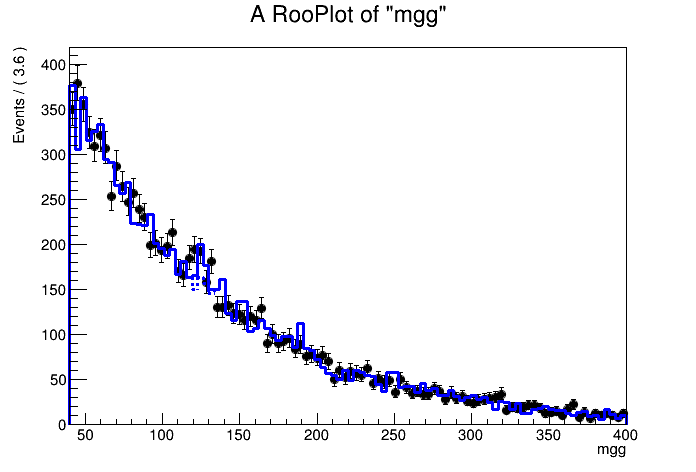

In [9]:
w.pdf("model")->fitTo(*hist_data) ;
TCanvas* c1 = new TCanvas();
RooPlot* frame = w.var("mgg")->frame() ;
hist_data->plotOn(frame) ;
w.pdf("model")->plotOn(frame) ;
w.pdf("model")->plotOn(frame,RooFit::Components("bkg"),RooFit::LineStyle(kDashed)) ;
frame->Draw() ;
c1->Draw();

Now save the workspace with the data a modelconfig so that you can use RooStats to extract limits

Create an empty ModelConfig

In [10]:
RooStats::ModelConfig mc("ModelConfig",&w);

Define the pdf, the parameter of interest and the observables

In [11]:
mc.SetPdf(*w.pdf("model"));
mc.SetParametersOfInterest(*w.var("mu"));
//mc.SetNuisanceParameters(RooArgSet(*w.var("mean"),*w.var("width"),*w.var("alpha")));
mc.SetNuisanceParameters(*w.var("Bscale"));
mc.SetObservables(*w.var("mgg"));

Define the current value $\mu=1$ as an hypothesis 

In [12]:
w.var("mu")->setVal(1) ;
mc.SetSnapshot(*w.var("mu"));

mc.Print();


=== Using the following for ModelConfig ===
Observables:             RooArgSet:: = (mgg)
Parameters of Interest:  RooArgSet:: = (mu)
Nuisance Parameters:     RooArgSet:: = (Bscale)
PDF:                     RooRealSumPdf::model[ S * sig + B * bkg ] = 2.77715
Snapshot:                
  1) 0x7fe4dca0cd80 RooRealVar:: mu = 1 +/- 0.486745  L(-1 - 6)  "mu"



import model in the workspace

In [13]:
w.import(mc);

w.writeToFile("model.root") ; 